# **0. Introduzione**

In questo notebook ripeteremo gli esperimenti del precedente ma utilizzando la versione bivariata della [funzione di Ackley](https://www.sfu.ca/~ssurjano/ackley.html).

Questa volta, invece di prendere dei campioni equispaziati dallo spazio dell'input, utilizziamo il *Latin Hypercube Sampling* per generare $6$ campioni in modo che coprano al meglio l'intero spazio degli input.

In [1]:
%%capture
!pip install pydoe

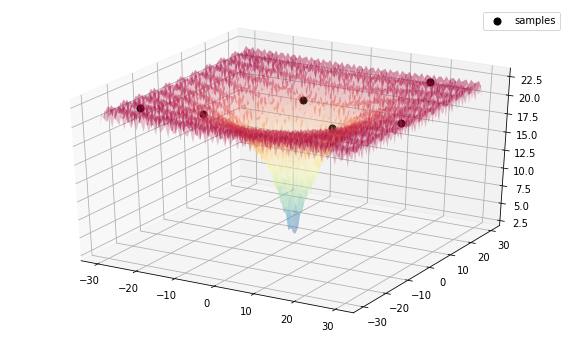

In [2]:
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from pyDOE import lhs
from scipy.stats.distributions import uniform

def seed(s = 0):
  random.seed(s)
  np.random.seed(s)
  tf.random.set_seed(s)

def fn(v, a = 20, b = 0.2, c = 2 * np.pi):
  # 2D Ackley
  d = v.shape[1]
  term1 = -a * np.exp(-b * np.sqrt(np.sum(v ** 2, axis=1) / d))
  term2 = -np.exp(np.sum(np.cos(c * v), axis=1) / d)
  return term1 + term2 + a + np.e

num = 6
span = 30
space = 100
hidden = [16, 16]

seed(0)
x = lhs(2, samples=num)
x = uniform(loc=-span, scale=2 * span).ppf(x)
x1, x2 = x[:, 0], x[:, 1]
y = fn(x)

s = np.linspace(-span, span, space, endpoint=True)
s1, s2 = np.meshgrid(s, s)
s = np.concatenate([s1.reshape(-1, 1), s2.reshape(-1, 1)], axis=1)
sT = fn(s)

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, sT.reshape(space, space), alpha=0.25, cmap='Spectral_r')
ax.scatter(x1, x2, y, color='black', s=50, depthshade=False, label='samples')
zlim = ax.get_zlim()
plt.legend()
plt.show()

# **1. Sampling Uniforme Simbolico**

Diversamente da quanto fatto nel precedente notebook, anche in questo usiamo il *Latin Hypercube Sampling* per andare a campionare lo spazio e ottenere nuovi dati aumentati, questo al fine di coprire il più possibile tutto lo spazio degl'input senza dover creare una vera e propria meshgrid che sarebbe o troppo sparsa o computazionalmente troppo pesante. 

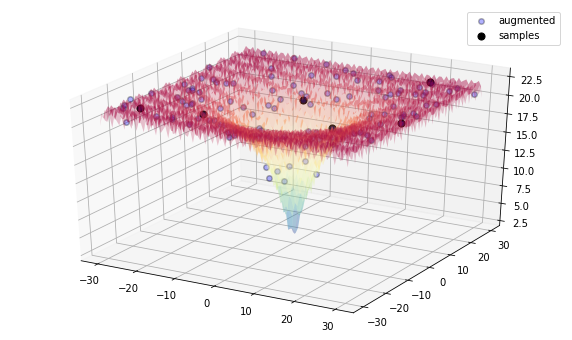

In [3]:
seed(0)

x_aug = lhs(2, samples=20 * num)
x_aug = uniform(loc=-span, scale=2 * span).ppf(x_aug)
x_aug = np.concatenate((x, x_aug), axis=0)
x1_aug, x2_aug = x_aug[:, 0], x_aug[:, 1]
y_aug = np.concatenate((y, [np.nan] * (20 * num)), axis=0)

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, sT.reshape(space, space), alpha=0.25, cmap='Spectral_r')
ax.scatter(x1_aug, x2_aug, fn(x_aug), color='blue', edgecolor='black', linewidth=1.5, s=30, alpha=0.3, depthshade=False, label='augmented')
ax.scatter(x1, x2, y, color='black', s=50, depthshade=False, label='samples')
plt.legend()
plt.show()

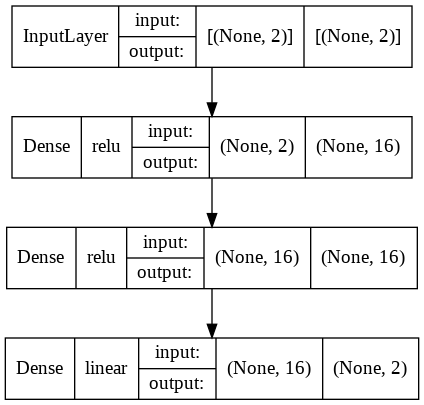

In [4]:
net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(2,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(2)
])

tf.keras.utils.plot_model(net, show_layer_names=False, show_layer_activations=True, show_shapes=True)

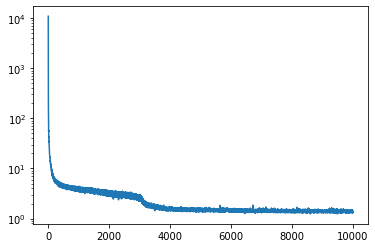

In [5]:
seed(0)
a = y.min()
b = y.max()
alpha = 0.5

def custom_loss(y_true, y_pred):
  # retrieve parameters
  mu = y_pred[:, :1]
  log_sigma = y_pred[:, 1:]
  sigma = tf.math.exp(log_sigma)
  sq_sigma = tf.math.square(sigma)
  # sampling loss computed on all the samples in order to increase the covariance
  sampling_loss = (a**2 + a*b + b**2) / (6. * sq_sigma) + mu * (mu - a - b) / (2. * sq_sigma) + 0.5 * tf.math.log(2. * np.pi) + 2. * log_sigma
  sampling_loss = tf.reduce_mean(sampling_loss)
  # input masking based on nan values
  mask = tf.logical_not(tf.math.is_nan(y_true))
  y_true = tf.boolean_mask(y_true, mask)
  mu = tf.boolean_mask(mu, mask)
  log_sigma = tf.boolean_mask(log_sigma, mask)
  sigma = tf.boolean_mask(sigma, mask)
  sq_sigma = tf.boolean_mask(sq_sigma, mask)
  # negative log-likelihood computed on the original samples only in order to compute the correct expected value
  log_likelihood = 0.5 * tf.math.squared_difference(y_true / sigma, mu / sigma) + 0.5 * tf.math.log(2. * np.pi) + log_sigma
  log_likelihood = tf.cond(tf.reduce_any(mask), lambda: tf.reduce_mean(log_likelihood), lambda: 0.0)
  # final loss built as a weighted sum of the two terms
  return (1 - alpha) * log_likelihood + alpha * sampling_loss


net.compile(optimizer='adam', loss=custom_loss)
history = net.fit(x_aug, y_aug, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

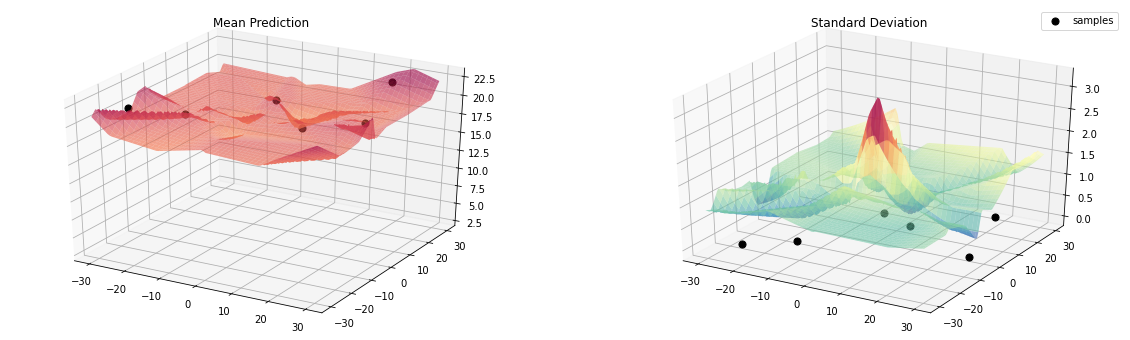

In [6]:
pred = net.predict(s)
mu = pred[:, 0]
sigma = np.exp(pred[:, 1])

plt.figure(figsize=(20, 6))
ax = plt.subplot(1, 2, 1, projection='3d')
ax.set_title('Mean Prediction')
ax.plot_surface(s1, s2, mu.reshape(space, space), alpha=0.6, vmin=sT.min(), vmax=sT.max(), cmap='Spectral_r')
ax.scatter(x1, x2, y, color='black', s=50, depthshade=False, label='samples')
ax.set_zlim(*zlim)
ax = plt.subplot(1, 2, 2, projection='3d')
ax.set_title('Standard Deviation')
ax.plot_surface(s1, s2, sigma.reshape(space, space), alpha=0.6, cmap='Spectral_r')
ax.scatter(x1, x2, np.zeros_like(x1), color='black', s=50, depthshade=False, label='samples')
plt.legend()
plt.show()

# **2. Raffinamento Esplicito della Deviazione Standard**



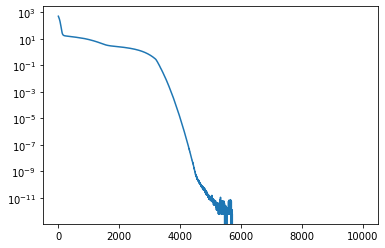

In [7]:
seed(0)

net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(2,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(1)
])

net.compile(optimizer='adam', loss='mse')
history = net.fit(x, y, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

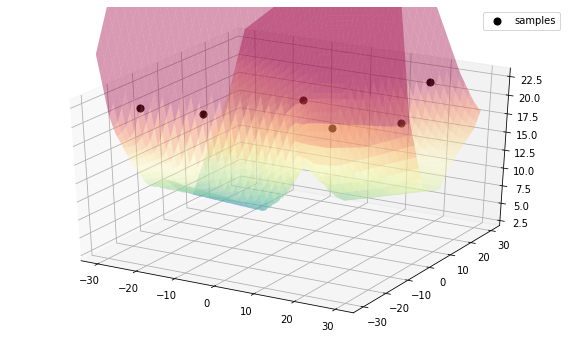

In [8]:
mu = net.predict(s)

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, mu.reshape(space, space), alpha=0.4, vmin=sT.min(), vmax=sT.max(), cmap='Spectral_r')
ax.scatter(x1, x2, y, color='black', s=50, depthshade=False, label='samples')
ax.set_zlim(*zlim)
plt.legend()
plt.show()

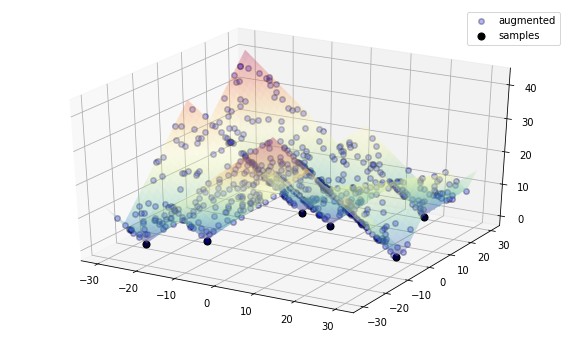

In [9]:
def abs_distance(samples, references):
  samples = np.repeat([samples], len(references), axis=0).transpose((1, 0, 2))
  distances = np.abs(samples - references).sum(axis=2)
  return distances.min(axis=1)

seed(0)
x_aug = lhs(2, samples=100 * num)
x_aug = uniform(loc=-span, scale=2 * span).ppf(x_aug)
x_aug = np.concatenate((x, x_aug), axis=0)
x1_aug, x2_aug = x_aug[:, 0], x_aug[:, 1]
y_std = abs_distance(x_aug, x)

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, abs_distance(s, x).reshape(space, space), alpha=0.3, cmap='Spectral_r')
ax.scatter(x1_aug, x2_aug, y_std, color='blue', edgecolor='black', linewidth=1.5, s=30, alpha=0.3, depthshade=False, label='augmented')
ax.scatter(x1, x2, np.zeros_like(x1), color='black', s=50, depthshade=False, label='samples')
plt.legend()
plt.show()

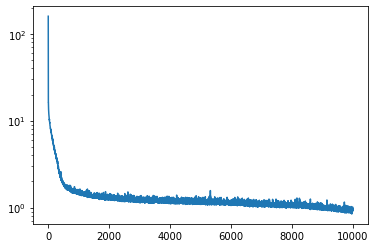

In [10]:
seed(0)

net.trainable = False
net_std = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(2,)),
    *net.layers[:-1],
    tf.keras.layers.Dense(1, activation='exponential')
])

net_std.compile(optimizer='adam', loss='mse')
history = net.fit(x_aug, y_std, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

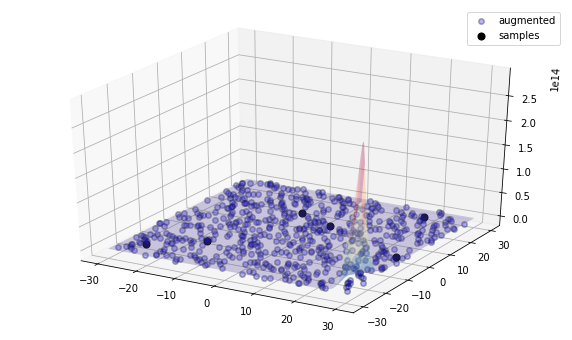

In [11]:
sigma = net_std.predict(s)

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, sigma.reshape(space, space), alpha=0.3, cmap='Spectral_r')
ax.scatter(x1_aug, x2_aug, y_std, color='blue', edgecolor='black', linewidth=1.5, s=30, alpha=0.3, depthshade=False, label='augmented')
ax.scatter(x1, x2, np.zeros_like(x1), color='black', s=50, depthshade=False, label='samples')
plt.legend()
plt.show()

# **3. Surrogato della Funzione di Acquisizione**

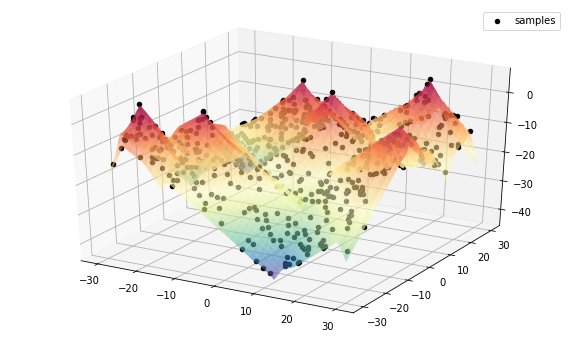

In [12]:
def acq_fn(v, surr, std_fn, lam = 2.0):
  return surr.predict(v).flatten() - lam * std_fn(v)

s_acq = acq_fn(s, surr=net, std_fn=lambda v: abs_distance(v, x))
y_acq = acq_fn(x_aug, surr=net, std_fn=lambda v: abs_distance(v, x))

plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, s_acq.reshape((space, space)), alpha=0.6, cmap='Spectral_r')
ax.scatter(x1_aug, x2_aug, y_acq, color='black', s=20, depthshade=False, label='samples')
plt.legend()
plt.show()

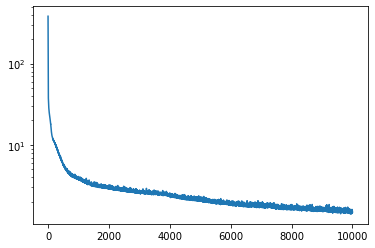

In [13]:
net = tf.keras.Sequential([
  tf.keras.layers.InputLayer(input_shape=(2,)),
  *[tf.keras.layers.Dense(h, activation='relu') for h in hidden],
  tf.keras.layers.Dense(1)
])

net.compile(optimizer='adam', loss='mse')
history = net.fit(x_aug, y_acq, epochs=10000, shuffle=True, verbose=False)
plt.plot(history.epoch, history.history['loss'])
plt.yscale('log')
plt.show()

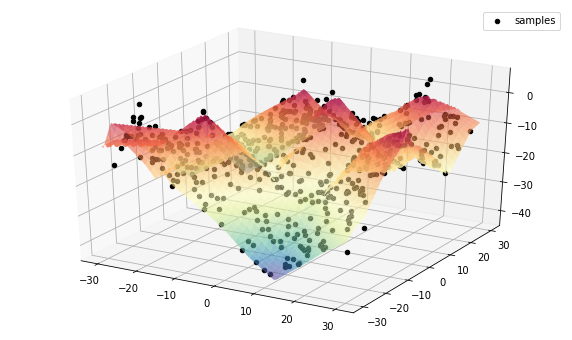

In [14]:
plt.figure(figsize=(10, 6))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.plot_surface(s1, s2, net.predict(s).reshape((space, space)), alpha=0.6, cmap='Spectral_r')
ax.scatter(x1_aug, x2_aug, y_acq, color='black', s=20, depthshade=False, label='samples')
plt.legend()
plt.show()